# Compare USDM & SPI - Category Frequency

a. stein 5.11.2022

Following the other `analysis/usdm_spi_compare_*.ipynb` ... this notebook further complicates spatio-temporal relations by looking at how often each cell is in each category as an aggregation scheme across time (and different time groupings) instead of spatial groupings.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


Setup some helpful lists

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

spi_intervals = ['1y', '2y', '5y', '14d', '30d', '90d', '180d', '270d']
cats = ['neutral_wet', 'D0', 'D1', 'D2', 'D3', 'D4']
colors = ['black', 'red', 'coral', 'peru', 'deepskyblue', 'steelblue', 'teal', 'lightblue', 'navy']

dm_vars = ['USDM']
dm_vars.extend([f'spi_{interval}' for interval in spi_intervals])
dm_vars

['USDM',
 'spi_1y',
 'spi_2y',
 'spi_5y',
 'spi_14d',
 'spi_30d',
 'spi_90d',
 'spi_180d',
 'spi_270d']

Pull in our existing products

In [3]:
paired_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI.nc')
#paired_huc4_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI_huc4split.nc')
#paired_huc8_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI_huc8split.nc')

In [4]:
paired_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
Data variables:
    spatial_ref  int64 ...
    USDM         (index, lat, lon) float64 ...
    USDM Date    (index) datetime64[ns] ...
    spi_1y       (index, lat, lon) float32 ...
    spi_2y       (index, lat, lon) float32 ...
    spi_5y       (index, lat, lon) float32 ...
    spi_14d      (index, lat, lon) float32 ...
    spi_30d      (index, lat, lon) float32 ...
    spi_90d      (index, lat, lon) float32 ...
    spi_180d     (index, lat, lon) float32 ...
    spi_270d     (index, lat, lon) float32 ...
    SPI Date     (index) datetime64[ns] ...
Attributes:
    author:       a. stein 5/2/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

Let's figure out how to count categorical occurrences per cell over time

In [13]:
paired_ds['USDM']

<xarray.DataArray 'USDM' (index: 1148, lat: 84, lon: 188)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * index    (index) int64 0 1 2 3 4 5 6 ... 1141 1142 1143 1144 1145 1146 1147
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -124.74590760646159 0.024999999999999963 0....
    grid_mapping:                 spatial_ref

In [15]:
np.shape(paired_ds['USDM'].values)

(1148, 84, 188)

In [18]:
1148*84*188

18129216

In [20]:
np.sum(paired_ds['USDM'].isel(lat=30, lon=50).values == 0)

173

In [40]:
USDM_D0 = np.array([[np.sum(paired_ds['USDM'].sel(lat=lat, lon=lon).values==0) for lon in paired_ds['lon']] for lat in paired_ds['lat']])

In [30]:
np.shape(USDM_D0)

(84, 188)

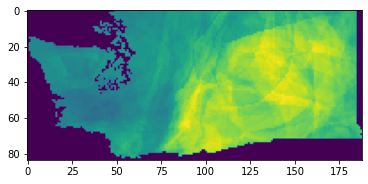

In [31]:
fig, ax = plt.subplots()

ax.imshow(USDM_D0)
ax.set_aspect('equal')

hehe, that's neat. Glad that works. should probably mask out by the nans of the original ...

In [44]:
USDM_D0_masked = np.ma.masked_where(np.isnan(paired_ds['USDM'].isel(index=0).values), USDM_D0)

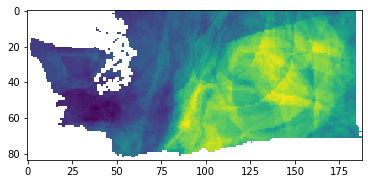

In [45]:
fig, ax = plt.subplots()

ax.imshow(USDM_D0_masked)

Cool.

I could probably normalize it by the total number of time indices.

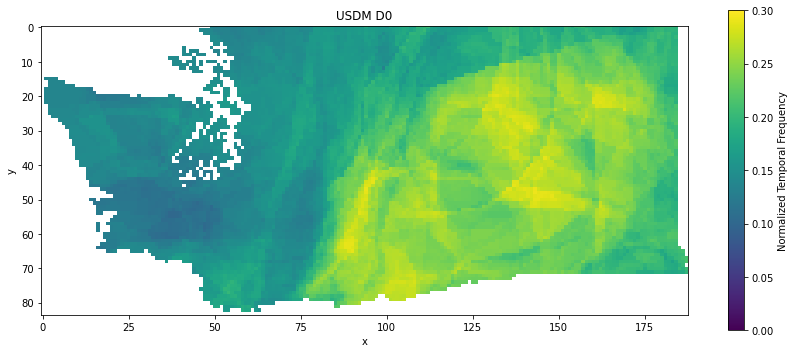

In [63]:
fig, ax = plt.subplots(figsize=(12,5))

plotted = ax.imshow(USDM_D0_masked/len(paired_ds['index'].values), vmin=0, vmax=0.3)
fig.colorbar(plotted, label='Normalized Temporal Frequency')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('USDM D0')
plt.tight_layout()

In [64]:
def cat_norm_time_freq(da:xr.DataArray, cat_val:int):
    """
    """

    cat_count = np.array([[np.sum(da.sel(lat=lat, lon=lon).values == cat_val) for lon in da['lon']] for lat in da['lat']])
    cat_tf = cat_count/len(da['index'].values)
    cat_tf_masked = np.ma.masked_where(np.isnan(da.isel(index=0).values), cat_tf)

    return cat_tf_masked

def compile_norm_time_freqs(da:xr.DataArray, var_prefix=None):
    """
    """

    neutral_wet = cat_time_frac(da, -1)
    d0 = cat_time_frac(da, 0)
    d1 = cat_time_frac(da, 1)
    d2 = cat_time_frac(da, 2)
    d3 = cat_time_frac(da, 3)
    d4 = cat_time_frac(da, 4)

    lon = da.lon.values
    lat = da.lat.values

    ds = xr.Dataset(
        coords=dict(
            lat=lat,
            lon=lon
        ),
        data_vars=dict(
            neutral_wet=(["lat", "lon"], neutral_wet),
            D0=(["lat", "lon"], d0),
            D1=(["lat", "lon"], d1),
            D2=(["lat", "lon"], d2),
            D3=(["lat", "lon"], d3),
            D4=(["lat", "lon"], d4),
        ),
        attrs=dict(
            {
                'description':'Temporal frequency each lat-lon cell is in each USDM drought category normalized by the total number of time indices.'
            }
        )
    )

    if var_prefix:
        ds = ds.rename({
            "neutral_wet":f"{var_prefix}_neutral_wet",
            "D0":f"{var_prefix}_D0",
            "D1":f"{var_prefix}_D1",
            "D2":f"{var_prefix}_D2",
            "D3":f"{var_prefix}_D3",
            "D4":f"{var_prefix}_D4"
        })

    return ds

In [66]:
USDM_cat_ntf = compile_norm_time_freqs(paired_ds['USDM'], 'USDM')

In [67]:
USDM_cat_ntf

<xarray.Dataset>
Dimensions:           (lat: 84, lon: 188)
Coordinates:
  * lat               (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon               (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -116.9
Data variables:
    USDM_neutral_wet  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    USDM_D0           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    USDM_D1           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    USDM_D2           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    USDM_D3           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    USDM_D4           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Temporal frequency each lat-lon cell is in each USDM drough...

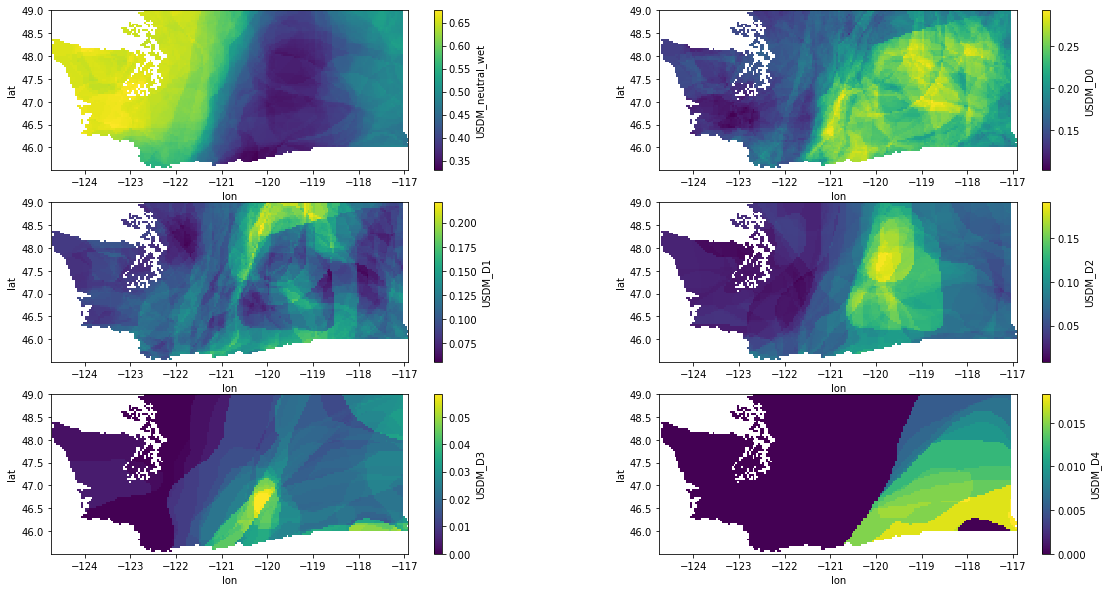

In [74]:
fig, axs = plt.subplots(3,2, figsize=(20,10))

for ax, cat in zip(axs.ravel(), cats):
    #USDM_cat_ntf[f'USDM_{cat}'].plot(ax=ax, vmin=0, vmax=1)
    USDM_cat_ntf[f'USDM_{cat}'].plot(ax=ax)
    ax.set_aspect('equal')

In [75]:
cat_ntf_list = [USDM_cat_ntf]

for interval in tqdm(spi_intervals):
    spi_ntf = compile_norm_time_freqs(paired_ds[f'spi_{interval}'], var_prefix=f"spi_{interval}")
    cat_ntf_list.append(spi_ntf)
    spi_ntf = None

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
cat_ntf_ds = xr.merge(cat_ntf_list)
cat_ntf_list

Awesome. I'mma go home for the day and am excited to pick this up tomorrow.